# LSTM Stock Predictor Using Closing Prices

### Data Preparation

### In this section, we will prepare the training and testing data for the LSTM model.

### We will need to:
    1. Use window_data function to generate X and y values for the model.
    2. Split the data into 70% training and 30% testing
    3. Apply the MinMaxScaler to the X and y values
    4. Reshape the X_train and X_test data for the model.
    
### **Note**: The required input format for the LSTM is:

            reshape((X_train.shape[0], X_train.shape[1], 1))    

In [20]:
# Initial imports
import numpy as np
import pandas as pd
from pathlib import Path
import yfinance as yf
%matplotlib inline

In [21]:
# Set the random seed for reproducibility
# Note: This is used for model prototyping, but it is good practice to comment this out and run multiple experiments to evaluate your model.
from numpy.random import seed

seed(1)
from tensorflow import random

random.set_seed(2)

### Data Loading

In this activity, we will use closing prices from different stocks to make predictions of future closing prices based on the temporal data of each stock.

In [23]:
# Historical Carnival Cruise Stock Price:
# OHLCV using yfinance
# Load the stocks data
ccl = yf.download("CCL", start="2016-01-01", end="2021-01-21", 
    index_col="Date", infer_datetime_format=True, parse_dates=True)
ccl.dropna(inplace=True)
#ccl.head()

[*********************100%***********************]  1 of 1 completed


In [24]:
# Historical Delta Airlines Stock Price:
# OHLCV using yfinance
# Load the stocks data
dal = yf.download("DAL", start="2016-01-01", end="2021-01-21", 
    index_col="Date", infer_datetime_format=True, parse_dates=True)
dal.dropna(inplace=True)
#dal.head()

[*********************100%***********************]  1 of 1 completed


In [25]:
# Historical ETSY Stock Price:
# OHLCV using yfinance
# Load the stocks data
etsy = yf.download("ETSY", start="2016-01-01", end="2021-01-21", 
    index_col="Date", infer_datetime_format=True, parse_dates=True)
etsy.dropna(inplace=True)
#etsy.head()

[*********************100%***********************]  1 of 1 completed


In [26]:
# Historical L Brands Stock Price:
# OHLCV using yfinance
# Load the stocks data
LB = yf.download("LB", start="2016-01-01", end="2021-01-21", 
    index_col="Date", infer_datetime_format=True, parse_dates=True)
LB.dropna(inplace=True)
#LB.head()

[*********************100%***********************]  1 of 1 completed


In [27]:
# Historical SPY Stock Price:
# OHLCV using yfinance
# Load the stocks data
spy = yf.download("SPY", start="2016-01-01", end="2021-01-21", 
    index_col="Date", infer_datetime_format=True, parse_dates=True)
spy.dropna(inplace=True)
#spy.head()

[*********************100%***********************]  1 of 1 completed


In [28]:
ccl_df = ccl[['Close']].copy()
dal_df = dal[['Close']].copy()
etsy_df = etsy[['Close']].copy()
LB_df = LB[['Close']].copy()
spy_df = spy[['Close']].copy()

In [33]:
ccl_df.rename(columns = {'Close':'CCL'}, inplace = True) 
dal_df.rename(columns = {'Close':'DAL'}, inplace = True) 
etsy_df.rename(columns = {'Close':'ETSY'}, inplace = True) 
LB_df.rename(columns = {'Close':'LB'}, inplace = True) 
spy_df.rename(columns = {'Close':'SPY'}, inplace = True) 
#spy_df.head()

In [39]:
dfs = [ccl_df, dal_df, etsy_df, LB_df,spy_df ]
df = pd.concat(dfs,axis=1,join="outer",ignore_index=False)
df.tail()

,CCL,DAL,ETSY,LB,SPY
Date,,,,,
2021-01-13,20.100000,40.450001,207.029999,46.160000,379.790009
2021-01-14,20.920000,41.470001,211.520004,44.980000,378.459991
2021-01-15,20.790001,39.980000,204.419998,45.200001,375.700012
2021-01-19,20.870001,40.310001,221.309998,45.730000,378.649994
2021-01-20,20.780001,41.619999,215.690002,45.560001,383.890015


### Creating the Features X and Target y Data

The first step towards preparing the data is to create the input features vectors X and the target vector y. We will use the window_data() function to create these vectors.

This function chunks the data up with a rolling window of Xt - window to predict Xt.

The function returns two numpy arrays:

 - X: The input features vectors.

 - y: The target vector.

The function has the following parameters:

 - df: The original DataFrame with the time series data.

 - window: The window size in days of previous closing prices that will be used for the prediction.

 - feature_col_number: The column number from the original DataFrame where the features are located.

 - target_col_number: The column number from the original DataFrame where the target is located.

In [41]:
def window_data(df, window, feature_col_number, target_col_number):
    """
    This function accepts the column number for the features (X) and the target (y).
    It chunks the data up with a rolling window of Xt - window to predict Xt.
    It returns two numpy arrays of X and y.
    """
    X = []
    y = []
    for i in range(len(df) - window):
        features = df.iloc[i : (i + window), feature_col_number]
        target = df.iloc[(i + window), target_col_number]
        X.append(features)
        y.append(target)
    return np.array(X), np.array(y).reshape(-1, 1)

We want to predict closing prices using a 5 days windows of previous closing prices, so that, we will create the X and y vectors by calling the window_data function and defining a window size of 5 and setting the features and target column numbers to (0, 1, 2, 3 )the respective column.

In [240]:
# Creating the features (X) and target (y) data using the window_data() function.
window_size = 10

feature_column = 4
target_column = 4
X, y = window_data(df, window_size, feature_column, target_column)
print (f"X sample values:\n{X[:5]} \n")
print (f"y sample values:\n{y[:5]}")

X sample values:
[[201.02000427 201.36000061 198.82000732 194.05000305 191.91999817
  192.11000061 193.66000366 188.83000183 191.92999268 187.80999756]
 [201.36000061 198.82000732 194.05000305 191.91999817 192.11000061
  193.66000366 188.83000183 191.92999268 187.80999756 188.05999756]
 [198.82000732 194.05000305 191.91999817 192.11000061 193.66000366
  188.83000183 191.92999268 187.80999756 188.05999756 185.6499939 ]
 [194.05000305 191.91999817 192.11000061 193.66000366 188.83000183
  191.92999268 187.80999756 188.05999756 185.6499939  186.69000244]
 [191.91999817 192.11000061 193.66000366 188.83000183 191.92999268
  187.80999756 188.05999756 185.6499939  186.69000244 190.52000427]] 

y sample values:
[[188.05999756]
 [185.6499939 ]
 [186.69000244]
 [190.52000427]
 [187.63999939]]


### Splitting Data Between Training and Testing Sets
To avoid the dataset being randomized, we will manually split the data using array slicing.

In [241]:
# Use 70% of the data for training and the remainder for testing
split = int(0.7 * len(X))
X_train = X[: split]
X_test = X[split:]
y_train = y[: split]
y_test = y[split:]

### Scaling Data with MinMaxScaler
Once the training and test datasets are created, we need to scale the data before training the LSTM model. We will use the MinMaxScaler from sklearn to scale all values between 0 and 1.

Note that we scale both features and target sets.

In [242]:
# Use the MinMaxScaler to scale data between 0 and 1.
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.fit(X)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
scaler.fit(y)
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

### Reshape Features Data for the LSTM Model
The LSTM API from Keras needs to receive the features data as a vertical vector, so that we need to reshape the X data in the form reshape((X_train.shape[0], X_train.shape[1], 1)).

Both sets, training, and testing are reshaped.

In [243]:
# Reshape the features for the model
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))
print (f"X_train sample values:\n{X_train[:5]} \n")
print (f"X_test sample values:\n{X_test[:5]}")

X_train sample values:
[[[0.0950686 ]
  [0.0968485 ]
  [0.08132902]
  [0.05640122]
  [0.04566531]
  [0.04662298]
  [0.0544355 ]
  [0.03009073]
  [0.04571568]
  [0.02494958]]

 [[0.0968485 ]
  [0.08355149]
  [0.05702202]
  [0.04566531]
  [0.04662298]
  [0.0544355 ]
  [0.03009073]
  [0.04571568]
  [0.02494958]
  [0.02620966]]

 [[0.08355149]
  [0.05858026]
  [0.04616794]
  [0.04662298]
  [0.0544355 ]
  [0.03009073]
  [0.04571568]
  [0.02494958]
  [0.02620966]
  [0.01406247]]

 [[0.05858026]
  [0.04742957]
  [0.04713616]
  [0.0544355 ]
  [0.03009073]
  [0.04571568]
  [0.02494958]
  [0.02620966]
  [0.01406247]
  [0.01930444]]

 [[0.04742957]
  [0.04842425]
  [0.05503467]
  [0.03009073]
  [0.04571568]
  [0.02494958]
  [0.02620966]
  [0.01406247]
  [0.01930444]
  [0.03860889]]] 

X_test sample values:
[[[0.59658677]
  [0.59852371]
  [0.58983888]
  [0.58694552]
  [0.59369954]
  [0.5942036 ]
  [0.58931448]
  [0.57903218]
  [0.58452611]
  [0.57615931]]

 [[0.59852371]
  [0.6059574 ]
  [0.593406

### Build and Train the LSTM RNN
In this section, we will design a custom LSTM RNN in Keras and fit (train) it using the training data we defined.

We will need to:

 1. Define the model architecture in Keras.

 2. Compile the model.

 3. Fit the model to the training data.

#### Importing the Keras Modules
The LSTM RNN model in Keras uses the Sequential model and the LSTM layer as we did before. However, there is a new type of layer called Dropout.

 - Dropout: Dropout is a regularization technique for reducing overfitting in neural networks. This type of layer applies the dropout technique to the input.

In [244]:
# Import required Keras modules
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

### Defining the LSTM RNN Model Structure
To create an LSTM RNN model, we will add LSTM layers. The return_sequences parameter needs to set to True every time we add a new LSTM layer, excluding the final layer. The input_shape is the number of time steps and the number of indicators

After each LSTM layer, we add a Dropout layer to prevent overfitting. The parameter passed to the Dropout layer is the fraction of nodes that will be drop on each epoch, for this demo, we will use a dropout value of 0.2, it means that on each epoch we will randomly drop 20% of the units.

The number of units in each LSTM layers, is equal to the size of the time window, in this demo, we are taking five previous  closing prices to predict the next closing price.

In [245]:
# Define the LSTM RNN model.
model = Sequential()

number_units = 5
dropout_fraction = 0.2

# Layer 1
model.add(LSTM(
    units=number_units,
    return_sequences=True,
    input_shape=(X_train.shape[1], 1))
    )
model.add(Dropout(dropout_fraction))
# Layer 2
model.add(LSTM(units=number_units, return_sequences=True))
model.add(Dropout(dropout_fraction))
# Layer 3
model.add(LSTM(units=number_units))#, return_sequences=True))
model.add(Dropout(dropout_fraction))

# Layer 4
#model.add(LSTM(units=number_units))
#model.add(Dropout(dropout_fraction))





# Output layer
model.add(Dense(1))

### Compiling the LSTM RNN Model
We will compile the model, using the adam optimizer, as loss function, we will use mean_square_error since the value we want to predict is continuous.

In [246]:
# Compile the model
model.compile(optimizer="adam", loss="mean_squared_error")

In [247]:
# Summarize the model
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_37 (LSTM)               (None, 10, 5)             140       
_________________________________________________________________
dropout_36 (Dropout)         (None, 10, 5)             0         
_________________________________________________________________
lstm_38 (LSTM)               (None, 10, 5)             220       
_________________________________________________________________
dropout_37 (Dropout)         (None, 10, 5)             0         
_________________________________________________________________
lstm_39 (LSTM)               (None, 5)                 220       
_________________________________________________________________
dropout_38 (Dropout)         (None, 5)                 0         
_________________________________________________________________
dense_10 (Dense)             (None, 1)               

### Training the Model
Once the model is defined, we train (fit) the model using 10 epochs. Since we are working with time-series data, it's important to set shuffle=False since it's necessary to keep the sequential order of the data.

We can experiment with the batch_size parameter; however, smaller batch size is recommended; in this demo, we will use a batch_size=1.

In [248]:
# Train the model
model.fit(X_train, y_train, epochs=10, shuffle=False, batch_size=15, verbose=1)

Epoch 1/10
59/59 [==============================] - 4s 7ms/step - loss: 0.0089
Epoch 2/10
59/59 [==============================] - 0s 7ms/step - loss: 0.0317
Epoch 3/10
59/59 [==============================] - 0s 7ms/step - loss: 0.0364
Epoch 4/10
59/59 [==============================] - 0s 8ms/step - loss: 0.0312
Epoch 5/10
59/59 [==============================] - 0s 7ms/step - loss: 0.0194
Epoch 6/10
59/59 [==============================] - 0s 7ms/step - loss: 0.0112
Epoch 7/10
59/59 [==============================] - 0s 7ms/step - loss: 0.0083
Epoch 8/10
59/59 [==============================] - 0s 7ms/step - loss: 0.0055
Epoch 9/10
59/59 [==============================] - 0s 7ms/step - loss: 0.0045
Epoch 10/10
59/59 [==============================] - 0s 7ms/step - loss: 0.0031


### Model Performance
In this section, we will evaluate the model using the test data.

We will need to:

 1. Evaluate the model using the X_test and y_test data.

 2. Use the X_test data to make predictions.

 3. Create a DataFrame of real (y_test) vs predicted values.

 4. Plot the Real vs predicted values as a line chart.

### Evaluate the Model
It's time to evaluate our model to assess its performance. We will use the evaluate method using the testing data.

In [249]:
# Evaluate the model
model.evaluate(X_test, y_test)

12/12 [==============================] - 1s 2ms/step - loss: 0.0124


0.012417896650731564

### Making Predictions
We will make some closing price predictions using our brand new LSTM RNN model and our testing data.

In [250]:
# Make some predictions
predicted = model.predict(X_test)

Since we scaled the original values using the MinMaxScaler, we need to recover the original prices to better understand the predictions.

We will use the inverse_transform() method of the scaler to decode the scaled values to their original scale.

In [251]:
# Recover the original prices instead of the scaled version
predicted_prices = scaler.inverse_transform(predicted)
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

### Plotting Predicted Vs. Real Prices
To plot the predicted vs. the real values, we will create a DataFrame.

In [252]:
# Create a DataFrame of Real and Predicted values
stocks = pd.DataFrame({
    "Real": real_prices.ravel(),
    "Predicted": predicted_prices.ravel()
    }, index = df.index[-len(real_prices): ])
stocks.tail()

,Real,Predicted
Date,,
2021-01-13,379.790009,331.031036
2021-01-14,378.459991,331.292053
2021-01-15,375.700012,331.565002
2021-01-19,378.649994,331.750885
2021-01-20,383.890015,332.352661


<AxesSubplot:xlabel='Date'>

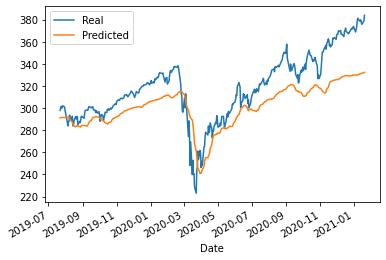

In [253]:
# Plot the real vs predicted prices as a line chart
stocks.plot()